<h1> Battle of Neighbourhoods in Munich
    
<h2> Business Problem


Munich ist the capital of the federal state of Bavaria. With its approximately 1.5 million inhabi-tants and many more in the metropolitan region it is the most densely populated area in Bava-ria and one of the most densely populated areas in Germany. 

Today, Munich is a global centre of art, science, technology, culture, innovation and tourism and enjoys a very high standard and quality of living, reaching first in Germany and third worldwide according to the 2018 Mercer survey.

The Bavarian cuisine contributes to this ranking, most popular ist the annual Oktoberfest whe-re millions of people enjoy the Bavarian cuisine. In small, there are countless traditional Bava-rian ale restaurants all over the city area, many of which also have small outside areas mostly with an encolsed beer garden. These are popular fixtures of Munich's gastronomic landscape. They are central to the city's culture and serve as a kind of melting pot for members of all walks of life, for locals, expatriates and tourists alike.

The objective of this project is to use Foursquare location data and regional clustering of ve-nue information as well as information about the population to determine what might be the ‘best’ neighbourhood in Munich to open a restaurant. Although there are many Bavarian res-taurants in the city area, in 2019 tourism in Munich recorded 8.8 million arrivals and many of them want to taste the traditional Bavarian cuisine.

Through this project, we will find the most suitable location for an entrepreneur to open a new Bavarian restaurant in Munich.



In [1]:
import types
import pandas as pd
import numpy as np
import json # library to handle JSON files

# Libraries for importing data

import requests
from botocore.client import Config
import ibm_boto3

# Visualization libraries

import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('ggplot')

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab

import folium

!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab

from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

# Machine Learning libraries

from sklearn.cluster import KMeans
from sklearn import preprocessing

print("Libraries installed and imported")

Solving environment: done

## Package Plan ##

  environment location: /opt/conda/envs/Python36

  added / updated specs: 
    - folium=0.5.0


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    vincent-0.4.4              |             py_1          28 KB  conda-forge
    openssl-1.1.1g             |       h516909a_1         2.1 MB  conda-forge
    ca-certificates-2020.6.20  |       hecda079_0         145 KB  conda-forge
    altair-4.1.0               |             py_1         614 KB  conda-forge
    python_abi-3.6             |          1_cp36m           4 KB  conda-forge
    branca-0.4.1               |             py_0          26 KB  conda-forge
    certifi-2020.6.20          |   py36h9f0ad1d_0         151 KB  conda-forge
    folium-0.5.0               |             py_0          45 KB  conda-forge
    ------------------------------------------------------------
                       

<h2> Data Section

#### Load population and density data from csv and location data of the neighbourhoods from Excel

In [2]:
# The code was removed by Watson Studio for sharing.

In [3]:
body_lat_lon = client_f77eb0a4a28b4c8a895ea7097b396fb9.get_object(Bucket='pythonbasicsfordatascienceproject-donotdelete-pr-ounhltxebnb12q',Key='neighbourhood_geodata.xlsx')['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body_lat_lon, "__iter__"): body_lat_lon.__iter__ = types.MethodType( __iter__, body_lat_lon )

#### Load geojson file for neighbourhoods

The geojson file is from open source air'b&b data base for munich

In [4]:
# Your data file was loaded into a botocore.response.StreamingBody object.
# Please read the documentation of ibm_boto3 and pandas to learn more about the possibilities to load the data.
# ibm_boto3 documentation: https://ibm.github.io/ibm-cos-sdk-python/
# pandas documentation: http://pandas.pydata.org/
munich_json = client_f77eb0a4a28b4c8a895ea7097b396fb9.get_object(Bucket='pythonbasicsfordatascienceproject-donotdelete-pr-ounhltxebnb12q', Key='neighbourhoods.geojson')['Body']
# add missing __iter__ method so pandas accepts body as file-like object
if not hasattr(munich_json, "__iter__"): munich_json.__iter__ = types.MethodType( __iter__, munich_json ) 


In [5]:
munich_data = json.load(munich_json)

In [6]:
body_listings = client_f77eb0a4a28b4c8a895ea7097b396fb9.get_object(Bucket='pythonbasicsfordatascienceproject-donotdelete-pr-ounhltxebnb12q',Key='listings.csv')['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body_listings, "__iter__"): body_listings.__iter__ = types.MethodType( __iter__, body_listings )

listings_data = pd.read_csv(body_listings)

In [7]:
listings_data.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,36720,"Beautiful 2 rooms flat, Glockenbach",158413,Gabriela,NaN,Ludwigsvorstadt-Isarvorstadt,48.13057,11.56929,Entire home/apt,95,2,25,2017-07-22,0.34,1,0
1,97945,Deluxw-Apartm. with roof terrace,517685,Angelika,NaN,Hadern,48.11476,11.48782,Entire home/apt,80,2,131,2019-10-03,1.23,2,82
2,114695,Apartment Munich/East with sundeck,581737,Stephan,NaN,Berg am Laim,48.11923,11.63726,Entire home/apt,95,2,53,2019-10-06,0.49,2,59
3,127383,City apartment next to Pinakothek,630556,Sonja,NaN,Maxvorstadt,48.15198,11.56486,Entire home/apt,120,2,84,2020-03-01,0.76,2,6
4,157808,"Near Olympia,English Garden",759734,Christian,NaN,Schwabing-West,48.16381,11.56089,Private room,35,1,0,NaN,NaN,1,0


In [8]:
munich_listings = pd.DataFrame(listings_data.neighbourhood.value_counts())
munich_listings.rename(columns={"neighbourhood": "Num_Listings_AIRBNB"}, inplace = True)
munich_listings.rename({"Schwanthalerhöhe": "Schwanthalerhoehe", "Thalkirchen-Obersendling-Forstenried-Fürstenried-Solln": "Thalkirchen-Obersendling-Forstenried-Fuerstenried-Solln", "Tudering-Riem": "Trudering-Riem"}, axis='index', inplace = True)
munich_listings.head()

,Num_Listings_AIRBNB
Ludwigsvorstadt-Isarvorstadt,1197
Maxvorstadt,1097
Schwabing-West,831
Neuhausen-Nymphenburg,761
Au-Haidhausen,713


### Create data frame with zip codes and attached coordinates

Postal Codes were collected muenchen.de. Munich has for every neighbourhood more than one zip code, so to make things easier only one zip code for every neighbourhood was chosen. The Latitude and Longitude were extracted from wikipedia.org and collected in one Excel sheet.

In [9]:
df_lat_lon = pd.read_excel(body_lat_lon)
df_lat_lon.set_index("Neighbourhood", drop = True, inplace = True)
df_lat_lon.head()

,Postal Code,Latitude,Longitude
Neighbourhood,,,
Altstadt-Lehel,80331,48.136111,11.572222
Ludwigsvorstadt-Isarvorstadt,80335,48.127222,11.564722
Maxvorstadt,80333,48.150000,11.569444
Schwabing-West,80809,48.161111,11.568889
Au-Haidhausen,81543,48.131944,11.588889


The data for Population, Area, Density and the percentage of whole population is from the open data portal of the city of Munich and was last updated on January 2019

In [10]:
df_pop = pd.read_csv(body_pop, encoding='ISO-8859-1')
df_pop.set_index("Neighbourhood", drop = True, inplace = True)
df_pop.head()

,Population,Area,Density,Percentage
Neighbourhood,,,,
Altstadt-Lehel,20422,314.57,65,1.39
Ludwigsvorstadt-Isarvorstadt,50620,440.14,115,3.46
Maxvorstadt,51642,429.79,120,3.53
Schwabing-West,65892,436.30,151,4.50
Au-Haidhausen,59752,421.96,142,4.08


Summarize the dataframes with population, density and location data into one dataframe

In [11]:
df_munich = df_pop.join(df_lat_lon, how = 'outer')
df_munich = df_munich.join(munich_listings, how = 'left')
df_munich

,Population,Area,Density,Percentage,Postal Code,Latitude,Longitude,Num_Listings_AIRBNB
Neighbourhood,,,,,,,,
Altstadt-Lehel,20422,314.57,65,1.39,80331,48.136111,11.572222,386
Ludwigsvorstadt-Isarvorstadt,50620,440.14,115,3.46,80335,48.127222,11.564722,1197
Maxvorstadt,51642,429.79,120,3.53,80333,48.150000,11.569444,1097
Schwabing-West,65892,436.30,151,4.50,80809,48.161111,11.568889,831
Au-Haidhausen,59752,421.96,142,4.08,81543,48.131944,11.588889,713
Sendling,39953,393.87,101,2.73,80336,48.121389,11.541389,447
Sendling-Westpark,55405,781.45,71,3.78,81377,48.122222,11.531944,391
Schwanthalerhoehe,29663,207.02,143,2.02,80339,48.138900,11.541700,430
Neuhausen-Nymphenburg,95906,1291.45,74,6.55,80634,48.156944,11.516667,761


In [12]:
print("Population of Munich:", str(np.sum(df_munich.Population)), "inhabitants")
print("Average Population per Neighbourhood:", str(np.mean(df_munich.Population)), "inhabitants")
print("Number of Neighbourhoods:", str(len(df_munich.index)))

Population of Munich: 1464961 inhabitants
Average Population per Neighbourhood: 58598.44 inhabitants
Number of Neighbourhoods: 25


<h1> Foursquare data

<h3> Define Foursquare Credentails and Version

In [13]:
# The code was removed by Watson Studio for sharing.

In [14]:
address = 'Munich, BY'

geolocator = Nominatim(user_agent="mu_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Munich are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Munich are 48.1371079, 11.5753822.


#### Top 100 venues that are in Munich within a radius of 1000 meters.

In [15]:
LIMIT = 100
radius = 1000

url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    latitude, 
    longitude, 
    radius, 
    LIMIT)

In [16]:
results = requests.get(url).json()
results

{'meta': {'code': 200, 'requestId': '5f4680c010aef4346c55407e'},
 'response': {'suggestedFilters': {'header': 'Tap to show:',
   'filters': [{'name': 'Open now', 'key': 'openNow'}]},
  'headerLocation': 'Hackenviertel',
  'headerFullLocation': 'Hackenviertel, Munich',
  'headerLocationGranularity': 'neighborhood',
  'totalResults': 234,
  'suggestedBounds': {'ne': {'lat': 48.14610790900001,
    'lng': 11.588843202667263},
   'sw': {'lat': 48.128107890999985, 'lng': 11.561921197332737}},
  'groups': [{'type': 'Recommended Places',
    'name': 'recommended',
    'items': [{'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '4ade0ccef964a520246921e3',
       'name': 'Marienplatz',
       'location': {'address': 'Marienplatz',
        'lat': 48.1371253550687,
        'lng': 11.5754829819069,
        'distance': 7,
        'postalCode': '80331',
        'cc': 'DE'

Transform JSON Data into dataframe

In [17]:
def getNearbyVenues(names, latitudes, longitudes, radius=1000):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighbourhood', 
                  'Neighbourhood Latitude', 
                  'Neighbourhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [18]:
# To adress the neighbourhood pull them from index into a column

df_munich_reindexed = df_munich.reset_index(level = 0)
df_munich_reindexed.head()

,Neighbourhood,Population,Area,Density,Percentage,Postal Code,Latitude,Longitude,Num_Listings_AIRBNB
0,Altstadt-Lehel,20422,314.57,65,1.39,80331,48.136111,11.572222,386
1,Ludwigsvorstadt-Isarvorstadt,50620,440.14,115,3.46,80335,48.127222,11.564722,1197
2,Maxvorstadt,51642,429.79,120,3.53,80333,48.150000,11.569444,1097
3,Schwabing-West,65892,436.30,151,4.50,80809,48.161111,11.568889,831
4,Au-Haidhausen,59752,421.96,142,4.08,81543,48.131944,11.588889,713


In [19]:
munich_venues = getNearbyVenues(names=df_munich_reindexed["Neighbourhood"],
                                   latitudes=df_munich_reindexed["Latitude"],
                                   longitudes=df_munich_reindexed["Longitude"]
                                  )

Altstadt-Lehel
Ludwigsvorstadt-Isarvorstadt
Maxvorstadt
Schwabing-West
Au-Haidhausen
Sendling
Sendling-Westpark
Schwanthalerhoehe
Neuhausen-Nymphenburg
Moosach
Milbertshofen-Am Hart
Schwabing-Freimann
Bogenhausen
Berg am Laim
Trudering-Riem
Ramersdorf-Perlach
Obergiesing
Untergiesing-Harlaching
Thalkirchen-Obersendling-Forstenried-Fuerstenried-Solln
Hadern
Pasing-Obermenzing
Aubing-Lochhausen-Langwied
Allach-Untermenzing
Feldmoching-Hasenbergl
Laim


In [20]:
print(munich_venues.shape)
munich_venues.head()

(1365, 7)


,Neighbourhood,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Altstadt-Lehel,48.136111,11.572222,Asamkirche (St. Johann Nepomuk),48.135053,11.569746,Church
1,Altstadt-Lehel,48.136111,11.572222,Marienplatz,48.137125,11.575483,Plaza
2,Altstadt-Lehel,48.136111,11.572222,Galeria Gourmet,48.137432,11.573217,Gourmet Shop
3,Altstadt-Lehel,48.136111,11.572222,La Burrita,48.136143,11.574489,Burrito Place
4,Altstadt-Lehel,48.136111,11.572222,Kustermann,48.136242,11.574897,Department Store


In [21]:
munich_venues.groupby('Neighbourhood').count()

,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighbourhood,,,,,,
Allach-Untermenzing,11,11,11,11,11,11
Altstadt-Lehel,100,100,100,100,100,100
Au-Haidhausen,100,100,100,100,100,100
Aubing-Lochhausen-Langwied,14,14,14,14,14,14
Berg am Laim,35,35,35,35,35,35
Bogenhausen,57,57,57,57,57,57
Feldmoching-Hasenbergl,21,21,21,21,21,21
Hadern,11,11,11,11,11,11
Laim,66,66,66,66,66,66


In [22]:
print('There are {} uniques categories.'.format(len(munich_venues['Venue Category'].unique())))

There are 218 uniques categories.


In [23]:
# one hot encoding
munich_onehot = pd.get_dummies(munich_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
munich_onehot['Neighbourhood'] = munich_venues['Neighbourhood'] 

# move neighborhood column to the first column
fixed_columns = [munich_onehot.columns[-1]] + list(munich_onehot.columns[:-1])
munich_onehot = munich_onehot[fixed_columns]

munich_onehot.head()

,Neighbourhood,Afghan Restaurant,African Restaurant,American Restaurant,Aquarium,Arcade,Argentinian Restaurant,Art Gallery,Art Museum,Asian Restaurant,...,Trattoria/Osteria,Tunnel,Turkish Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Wine Bar,Wine Shop,Xinjiang Restaurant,Yoga Studio,Zoo Exhibit
0,Altstadt-Lehel,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Altstadt-Lehel,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Altstadt-Lehel,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Altstadt-Lehel,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Altstadt-Lehel,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Absolute number of Restaurants 

In [24]:
munich_grouped = munich_onehot.groupby('Neighbourhood').mean().reset_index()
munich_grouped

,Neighbourhood,Afghan Restaurant,African Restaurant,American Restaurant,Aquarium,Arcade,Argentinian Restaurant,Art Gallery,Art Museum,Asian Restaurant,...,Trattoria/Osteria,Tunnel,Turkish Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Wine Bar,Wine Shop,Xinjiang Restaurant,Yoga Studio,Zoo Exhibit
0,Allach-Untermenzing,0.00,0.00,0.000000,0.000000,0.000000,0.00,0.000000,0.000,0.000000,...,0.090909,0.090909,0.000000,0.00,0.000000,0.00,0.00,0.00,0.000000,0.000000
1,Altstadt-Lehel,0.00,0.00,0.000000,0.000000,0.000000,0.01,0.000000,0.010,0.010000,...,0.010000,0.000000,0.000000,0.01,0.000000,0.01,0.00,0.00,0.000000,0.000000
2,Au-Haidhausen,0.01,0.00,0.000000,0.000000,0.000000,0.00,0.010000,0.000,0.000000,...,0.010000,0.000000,0.000000,0.01,0.000000,0.02,0.00,0.00,0.010000,0.000000
3,Aubing-Lochhausen-Langwied,0.00,0.00,0.000000,0.000000,0.000000,0.00,0.000000,0.000,0.000000,...,0.000000,0.000000,0.000000,0.00,0.000000,0.00,0.00,0.00,0.000000,0.000000
4,Berg am Laim,0.00,0.00,0.000000,0.000000,0.000000,0.00,0.000000,0.000,0.057143,...,0.000000,0.000000,0.000000,0.00,0.000000,0.00,0.00,0.00,0.000000,0.000000
5,Bogenhausen,0.00,0.00,0.000000,0.000000,0.000000,0.00,0.000000,0.000,0.035088,...,0.017544,0.000000,0.000000,0.00,0.000000,0.00,0.00,0.00,0.000000,0.000000
6,Feldmoching-Hasenbergl,0.00,0.00,0.000000,0.000000,0.000000,0.00,0.000000,0.000,0.000000,...,0.000000,0.000000,0.000000,0.00,0.000000,0.00,0.00,0.00,0.000000,0.000000
7,Hadern,0.00,0.00,0.000000,0.000000,0.000000,0.00,0.000000,0.000,0.000000,...,0.000000,0.000000,0.000000,0.00,0.000000,0.00,0.00,0.00,0.000000,0.000000
8,Laim,0.00,0.00,0.015152,0.000000,0.000000,0.00,0.000000,0.000,0.000000,...,0.015152,0.000000,0.000000,0.00,0.000000,0.00,0.00,0.00,0.015152,0.000000
9,Ludwigsvorstadt-Isarvorstadt,0.02,0.01,0.000000,0.000000,0.000000,0.00,0.010000,0.000,0.040000,...,0.000000,0.000000,0.000000,0.00,0.040000,0.00,0.00,0.01,0.000000,0.000000


In [25]:
bavarian_onehot = munich_grouped[["Neighbourhood","Bavarian Restaurant", "Beer Garden", "German Restaurant"]]
bavarian_onehot["Bavarian Restaurant Grouped"] = bavarian_onehot.sum(axis = 1)
bavarian_onehot #.head() shows the first five rows only

/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


,Neighbourhood,Bavarian Restaurant,Beer Garden,German Restaurant,Bavarian Restaurant Grouped
0,Allach-Untermenzing,0.181818,0.000000,0.000000,0.181818
1,Altstadt-Lehel,0.050000,0.010000,0.050000,0.110000
2,Au-Haidhausen,0.010000,0.030000,0.050000,0.090000
3,Aubing-Lochhausen-Langwied,0.000000,0.000000,0.071429,0.071429
4,Berg am Laim,0.028571,0.000000,0.057143,0.085714
5,Bogenhausen,0.000000,0.017544,0.000000,0.017544
6,Feldmoching-Hasenbergl,0.000000,0.000000,0.000000,0.000000
7,Hadern,0.000000,0.000000,0.000000,0.000000
8,Laim,0.000000,0.000000,0.000000,0.000000
9,Ludwigsvorstadt-Isarvorstadt,0.020000,0.000000,0.030000,0.050000


#### Get the absolute amount of Bavarian and German restuarants as well as Beer Gardens (count as one category in Munich) per nieghbourhood

In [26]:
munich_grouped_bavarian_sum = munich_onehot.groupby('Neighbourhood').sum().reset_index()
bavarian_onehot_sum = munich_grouped_bavarian_sum[["Neighbourhood","Bavarian Restaurant", "Beer Garden", "German Restaurant"]]
bavarian_onehot_sum["Bavarian Restaurant Grouped"] = bavarian_onehot_sum.sum(axis = 1)
bavarian_onehot_sum

/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


,Neighbourhood,Bavarian Restaurant,Beer Garden,German Restaurant,Bavarian Restaurant Grouped
0,Allach-Untermenzing,2,0,0,2
1,Altstadt-Lehel,5,1,5,11
2,Au-Haidhausen,1,3,5,9
3,Aubing-Lochhausen-Langwied,0,0,1,1
4,Berg am Laim,1,0,2,3
5,Bogenhausen,0,1,0,1
6,Feldmoching-Hasenbergl,0,0,0,0
7,Hadern,0,0,0,0
8,Laim,0,0,0,0
9,Ludwigsvorstadt-Isarvorstadt,2,0,3,5


In [27]:
munich_grouped.drop(columns = ["Bavarian Restaurant", "Beer Garden", "German Restaurant"], inplace = True)
munich_grouped = munich_grouped.join(bavarian_onehot["Bavarian Restaurant Grouped"], how = "left")
munich_grouped

,Neighbourhood,Afghan Restaurant,African Restaurant,American Restaurant,Aquarium,Arcade,Argentinian Restaurant,Art Gallery,Art Museum,Asian Restaurant,...,Tunnel,Turkish Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Wine Bar,Wine Shop,Xinjiang Restaurant,Yoga Studio,Zoo Exhibit,Bavarian Restaurant Grouped
0,Allach-Untermenzing,0.00,0.00,0.000000,0.000000,0.000000,0.00,0.000000,0.000,0.000000,...,0.090909,0.000000,0.00,0.000000,0.00,0.00,0.00,0.000000,0.000000,0.181818
1,Altstadt-Lehel,0.00,0.00,0.000000,0.000000,0.000000,0.01,0.000000,0.010,0.010000,...,0.000000,0.000000,0.01,0.000000,0.01,0.00,0.00,0.000000,0.000000,0.110000
2,Au-Haidhausen,0.01,0.00,0.000000,0.000000,0.000000,0.00,0.010000,0.000,0.000000,...,0.000000,0.000000,0.01,0.000000,0.02,0.00,0.00,0.010000,0.000000,0.090000
3,Aubing-Lochhausen-Langwied,0.00,0.00,0.000000,0.000000,0.000000,0.00,0.000000,0.000,0.000000,...,0.000000,0.000000,0.00,0.000000,0.00,0.00,0.00,0.000000,0.000000,0.071429
4,Berg am Laim,0.00,0.00,0.000000,0.000000,0.000000,0.00,0.000000,0.000,0.057143,...,0.000000,0.000000,0.00,0.000000,0.00,0.00,0.00,0.000000,0.000000,0.085714
5,Bogenhausen,0.00,0.00,0.000000,0.000000,0.000000,0.00,0.000000,0.000,0.035088,...,0.000000,0.000000,0.00,0.000000,0.00,0.00,0.00,0.000000,0.000000,0.017544
6,Feldmoching-Hasenbergl,0.00,0.00,0.000000,0.000000,0.000000,0.00,0.000000,0.000,0.000000,...,0.000000,0.000000,0.00,0.000000,0.00,0.00,0.00,0.000000,0.000000,0.000000
7,Hadern,0.00,0.00,0.000000,0.000000,0.000000,0.00,0.000000,0.000,0.000000,...,0.000000,0.000000,0.00,0.000000,0.00,0.00,0.00,0.000000,0.000000,0.000000
8,Laim,0.00,0.00,0.015152,0.000000,0.000000,0.00,0.000000,0.000,0.000000,...,0.000000,0.000000,0.00,0.000000,0.00,0.00,0.00,0.015152,0.000000,0.000000
9,Ludwigsvorstadt-Isarvorstadt,0.02,0.01,0.000000,0.000000,0.000000,0.00,0.010000,0.000,0.040000,...,0.000000,0.000000,0.00,0.040000,0.00,0.00,0.01,0.000000,0.000000,0.050000


In [28]:
num_top_venues = 5

for hood in munich_grouped['Neighbourhood']:
    print("----"+hood+"----")
    temp = munich_grouped[munich_grouped['Neighbourhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Allach-Untermenzing----
                         venue  freq
0  Bavarian Restaurant Grouped  0.18
1           Italian Restaurant  0.09
2                 Soccer Field  0.09
3                       Bakery  0.09
4             Lottery Retailer  0.09


----Altstadt-Lehel----
                         venue  freq
0  Bavarian Restaurant Grouped  0.11
1                         Café  0.07
2                  Coffee Shop  0.06
3                        Plaza  0.05
4           Italian Restaurant  0.04


----Au-Haidhausen----
                         venue  freq
0  Bavarian Restaurant Grouped  0.09
1           Italian Restaurant  0.07
2                  Coffee Shop  0.07
3                         Café  0.06
4                        Hotel  0.05


----Aubing-Lochhausen-Langwied----
                         venue  freq
0                       Bakery  0.29
1                  Supermarket  0.14
2  Bavarian Restaurant Grouped  0.07
3            Indian Restaurant  0.07
4             Greek Restaurant  0.0

In [29]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [30]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighbourhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighbourhoods_venues_sorted = pd.DataFrame(columns=columns)
neighbourhoods_venues_sorted['Neighbourhood'] = munich_grouped['Neighbourhood']

for ind in np.arange(munich_grouped.shape[0]):
    neighbourhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(munich_grouped.iloc[ind, :], num_top_venues)

neighbourhoods_venues_sorted.head()

,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Allach-Untermenzing,Bavarian Restaurant Grouped,Tunnel,Soccer Field,Supermarket,Bakery,Tennis Court,Italian Restaurant,Trattoria/Osteria,Lottery Retailer,Hotel
1,Altstadt-Lehel,Bavarian Restaurant Grouped,Café,Coffee Shop,Plaza,Hotel,Italian Restaurant,Department Store,Cocktail Bar,Gourmet Shop,Boutique
2,Au-Haidhausen,Bavarian Restaurant Grouped,Italian Restaurant,Coffee Shop,Café,Hotel,Cocktail Bar,Plaza,Bar,Concert Hall,Ice Cream Shop
3,Aubing-Lochhausen-Langwied,Bakery,Supermarket,Indian Restaurant,Soccer Field,Light Rail Station,Bus Stop,Post Office,Greek Restaurant,Bavarian Restaurant Grouped,Hotel
4,Berg am Laim,Bus Stop,Supermarket,Bavarian Restaurant Grouped,Hotel,Asian Restaurant,Bakery,Grocery Store,Pool,Metro Station,Laundromat


<h1> Cluster Neighbourhoods

Run *k*-means to cluster the neighborhood into 5 clusters.

In [31]:
# set number of clusters
kclusters = 3

munich_grouped_clustering = munich_grouped.drop('Neighbourhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(munich_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_

array([1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1,
       1, 1, 2], dtype=int32)

In [32]:
# add clustering labels
neighbourhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

In [33]:
munich_merged = df_munich_reindexed

munich_merged = munich_merged.join(neighbourhoods_venues_sorted.set_index('Neighbourhood'), on='Neighbourhood')

munich_merged["Bavarian Restaurants"] = bavarian_onehot_sum["Bavarian Restaurant Grouped"]

munich_merged.head() # check the last columns!

,Neighbourhood,Population,Area,Density,Percentage,Postal Code,Latitude,Longitude,Num_Listings_AIRBNB,Cluster Labels,...,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Bavarian Restaurants
0,Altstadt-Lehel,20422,314.57,65,1.39,80331,48.136111,11.572222,386,0,...,Café,Coffee Shop,Plaza,Hotel,Italian Restaurant,Department Store,Cocktail Bar,Gourmet Shop,Boutique,2
1,Ludwigsvorstadt-Isarvorstadt,50620,440.14,115,3.46,80335,48.127222,11.564722,1197,0,...,Bar,Italian Restaurant,Bavarian Restaurant Grouped,Asian Restaurant,Vietnamese Restaurant,Ice Cream Shop,Pizza Place,Restaurant,Cocktail Bar,11
2,Maxvorstadt,51642,429.79,120,3.53,80333,48.150000,11.569444,1097,0,...,Italian Restaurant,Art Museum,Bar,History Museum,Vietnamese Restaurant,Bakery,Burger Joint,Ice Cream Shop,Steakhouse,9
3,Schwabing-West,65892,436.30,151,4.50,80809,48.161111,11.568889,831,0,...,Italian Restaurant,Café,Vietnamese Restaurant,Trattoria/Osteria,Bavarian Restaurant Grouped,Pizza Place,Greek Restaurant,Thai Restaurant,Plaza,1
4,Au-Haidhausen,59752,421.96,142,4.08,81543,48.131944,11.588889,713,0,...,Italian Restaurant,Coffee Shop,Café,Hotel,Cocktail Bar,Plaza,Bar,Concert Hall,Ice Cream Shop,3


In [34]:
df_munich_reindexed_merged = df_munich_reindexed.merge(bavarian_onehot_sum, on = "Neighbourhood", how = "left")
df_munich_reindexed_merged.drop(columns = ["Bavarian Restaurant", "German Restaurant", "Beer Garden"], inplace = True)
df_munich_reindexed_merged

,Neighbourhood,Population,Area,Density,Percentage,Postal Code,Latitude,Longitude,Num_Listings_AIRBNB,Bavarian Restaurant Grouped
0,Altstadt-Lehel,20422,314.57,65,1.39,80331,48.136111,11.572222,386,11
1,Ludwigsvorstadt-Isarvorstadt,50620,440.14,115,3.46,80335,48.127222,11.564722,1197,5
2,Maxvorstadt,51642,429.79,120,3.53,80333,48.150000,11.569444,1097,3
3,Schwabing-West,65892,436.30,151,4.50,80809,48.161111,11.568889,831,3
4,Au-Haidhausen,59752,421.96,142,4.08,81543,48.131944,11.588889,713,9
5,Sendling,39953,393.87,101,2.73,80336,48.121389,11.541389,447,4
6,Sendling-Westpark,55405,781.45,71,3.78,81377,48.122222,11.531944,391,3
7,Schwanthalerhoehe,29663,207.02,143,2.02,80339,48.138900,11.541700,430,9
8,Neuhausen-Nymphenburg,95906,1291.45,74,6.55,80634,48.156944,11.516667,761,4
9,Moosach,51537,1109.36,46,3.52,80997,48.183333,11.516667,250,1


<h2> Examine Clusters

<h3> Cluster 0

In [35]:
cluster0 = munich_merged.loc[munich_merged['Cluster Labels'] == 0, munich_merged.columns[[0] + list(range(8, munich_merged.shape[1]))]]
cluster0.head()

,Neighbourhood,Num_Listings_AIRBNB,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Bavarian Restaurants
0,Altstadt-Lehel,386,0,Bavarian Restaurant Grouped,Café,Coffee Shop,Plaza,Hotel,Italian Restaurant,Department Store,Cocktail Bar,Gourmet Shop,Boutique,2
1,Ludwigsvorstadt-Isarvorstadt,1197,0,Café,Bar,Italian Restaurant,Bavarian Restaurant Grouped,Asian Restaurant,Vietnamese Restaurant,Ice Cream Shop,Pizza Place,Restaurant,Cocktail Bar,11
2,Maxvorstadt,1097,0,Café,Italian Restaurant,Art Museum,Bar,History Museum,Vietnamese Restaurant,Bakery,Burger Joint,Ice Cream Shop,Steakhouse,9
3,Schwabing-West,831,0,Bar,Italian Restaurant,Café,Vietnamese Restaurant,Trattoria/Osteria,Bavarian Restaurant Grouped,Pizza Place,Greek Restaurant,Thai Restaurant,Plaza,1
4,Au-Haidhausen,713,0,Bavarian Restaurant Grouped,Italian Restaurant,Coffee Shop,Café,Hotel,Cocktail Bar,Plaza,Bar,Concert Hall,Ice Cream Shop,3


<h3> Cluster 1

In [36]:
cluster1 = munich_merged.loc[munich_merged['Cluster Labels'] == 1, munich_merged.columns[[0] + list(range(8, munich_merged.shape[1]))]]
cluster1.head()

,Neighbourhood,Num_Listings_AIRBNB,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Bavarian Restaurants
5,Sendling,447,1,Supermarket,Hotel,Bakery,Bus Stop,Restaurant,Bavarian Restaurant Grouped,Café,Italian Restaurant,Vietnamese Restaurant,Gastropub,1
6,Sendling-Westpark,391,1,Hotel,Supermarket,Drugstore,Bus Stop,Bavarian Restaurant Grouped,Bakery,Café,Gym,Ice Cream Shop,Indian Restaurant,0
9,Moosach,250,1,Bakery,Supermarket,Drugstore,Hotel,Bus Stop,Light Rail Station,Asian Restaurant,Newsstand,Sandwich Place,Café,5
10,Milbertshofen-Am Hart,465,1,Bus Stop,Bavarian Restaurant Grouped,Museum,Shipping Store,Rental Car Location,Pet Store,Concert Hall,Cosmetics Shop,Mobile Phone Shop,Thai Restaurant,3
11,Schwabing-Freimann,601,1,Hotel,Bus Stop,Supermarket,Restaurant,Cafeteria,Lounge,Gym / Fitness Center,Metro Station,Shipping Store,Coffee Shop,1


<h3> Cluster 2

In [37]:
cluster2 = munich_merged.loc[munich_merged['Cluster Labels'] == 2, munich_merged.columns[[0] + list(range(8, munich_merged.shape[1]))]]
cluster2.head()

,Neighbourhood,Num_Listings_AIRBNB,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Bavarian Restaurants
17,Untergiesing-Harlaching,347,2,Zoo Exhibit,Bavarian Restaurant Grouped,Supermarket,Bus Stop,Convenience Store,Tram Station,Café,Plaza,Playground,Trail,1


In [38]:
df_munich_bavarian = bavarian_onehot[["Neighbourhood", "Bavarian Restaurant Grouped"]]
df_munich_cluster_label = munich_merged[["Neighbourhood", "Cluster Labels"]]
df_munich_bavarian_label = df_munich_bavarian.merge(df_munich_cluster_label, how = "left")
df_munich_bavarian_label

,Neighbourhood,Bavarian Restaurant Grouped,Cluster Labels
0,Allach-Untermenzing,0.181818,1
1,Altstadt-Lehel,0.110000,0
2,Au-Haidhausen,0.090000,0
3,Aubing-Lochhausen-Langwied,0.071429,1
4,Berg am Laim,0.085714,1
5,Bogenhausen,0.017544,0
6,Feldmoching-Hasenbergl,0.000000,1
7,Hadern,0.000000,1
8,Laim,0.000000,1
9,Ludwigsvorstadt-Isarvorstadt,0.050000,0


In [39]:
df_munich_bavarian_label_grouped = df_munich_bavarian_label.groupby('Cluster Labels').mean().reset_index()
df_munich_bavarian_label_grouped

,Cluster Labels,Bavarian Restaurant Grouped
0,0,0.063511
1,1,0.044246
2,2,0.108108


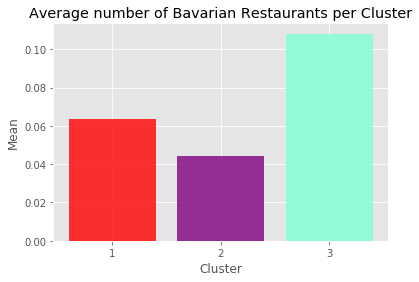

In [40]:
objects = (1, 2, 3)
y_pos = df_munich_bavarian_label_grouped["Cluster Labels"]
perf = df_munich_bavarian_label_grouped["Bavarian Restaurant Grouped"]
plt.bar(y_pos, perf, align='center', alpha=0.8, color=['red', 'purple','aquamarine'])
plt.xticks(y_pos, objects)
plt.ylabel('Mean')
plt.xlabel('Cluster')
plt.title('Average number of Bavarian Restaurants per Cluster')

plt.show()

<h3> Visualize results with Folium

Choropleth map to visualize the population in each neighbourhood

In [41]:
# create a choropleth map of munich showing neighbourhoods with AirB&B Listings

munich_venue_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

munich_venue_clusters.choropleth(
    geo_data=munich_data,
    data=df_munich_reindexed_merged,
    columns=['Neighbourhood', 'Num_Listings_AIRBNB'],
    key_on='feature.properties.neighbourhood',
    fill_color='YlOrRd', 
    fill_opacity=0.7, 
    line_opacity=0.2,
    legend_name='Air B&B Appartments in Munich',
    reset=True
)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(munich_merged['Latitude'], munich_merged['Longitude'], munich_merged['Neighbourhood'], munich_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(munich_venue_clusters)
       
munich_venue_clusters

In [63]:
# create a choropleth map of munich showing neighbourhoods with population

munich_venue_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

munich_venue_clusters.choropleth(
    geo_data=munich_data,
    data=df_munich_reindexed_merged,
    columns=['Neighbourhood', 'Population'],
    key_on='feature.properties.neighbourhood',
    fill_color='YlOrRd', 
    fill_opacity=0.7, 
    line_opacity=0.2,
    legend_name='Population in Munich',
    reset=True
)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(munich_merged['Latitude'], munich_merged['Longitude'], munich_merged['Neighbourhood'], munich_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(munich_venue_clusters)
       
munich_venue_clusters

### Statistics

In [61]:
munich_stats = df_munich_reindexed_merged.copy()
munich_stats.drop(columns = ["Percentage", "Postal Code", "Latitude", "Longitude"], inplace = True)
munich_stats.set_index("Neighbourhood", inplace = True)
munich_stats["Ratio_AIRBNB"] = munich_stats["Bavarian Restaurant Grouped"] / munich_stats["Num_Listings_AIRBNB"]
munich_stats["Ratio_Pop"] = munich_stats["Bavarian Restaurant Grouped"] / munich_stats["Population"]
munich_stats

,Population,Area,Density,Num_Listings_AIRBNB,Bavarian Restaurant Grouped,Ratio_AIRBNB,Ratio_Pop
Neighbourhood,,,,,,,
Altstadt-Lehel,20422,314.57,65,386,11,0.028497,0.000539
Ludwigsvorstadt-Isarvorstadt,50620,440.14,115,1197,5,0.004177,0.000099
Maxvorstadt,51642,429.79,120,1097,3,0.002735,0.000058
Schwabing-West,65892,436.30,151,831,3,0.003610,0.000046
Au-Haidhausen,59752,421.96,142,713,9,0.012623,0.000151
Sendling,39953,393.87,101,447,4,0.008949,0.000100
Sendling-Westpark,55405,781.45,71,391,3,0.007673,0.000054
Schwanthalerhoehe,29663,207.02,143,430,9,0.020930,0.000303
Neuhausen-Nymphenburg,95906,1291.45,74,761,4,0.005256,0.000042


In [64]:
munich_stats.sort_values(by = "Ratio_AIRBNB", ascending = True)

,Population,Area,Density,Num_Listings_AIRBNB,Bavarian Restaurant Grouped,Ratio_AIRBNB,Ratio_Pop
Neighbourhood,,,,,,,
Laim,54030,528.59,102,380,0,0.000000,0.000000
Hadern,48945,922.37,53,136,0,0.000000,0.000000
Thalkirchen-Obersendling-Forstenried-Fuerstenried-Solln,90790,1776.31,51,410,0,0.000000,0.000000
Trudering-Riem,67009,2245.05,30,302,0,0.000000,0.000000
Feldmoching-Hasenbergl,59391,2893.78,21,116,0,0.000000,0.000000
Schwabing-Freimann,69676,2567.22,27,601,1,0.001664,0.000014
Bogenhausen,82138,2370.97,35,516,1,0.001938,0.000012
Milbertshofen-Am Hart,73617,1341.64,55,465,1,0.002151,0.000014
Maxvorstadt,51642,429.79,120,1097,3,0.002735,0.000058


In [65]:
munich_stats.sort_values(by = "Ratio_Pop", ascending = True)

,Population,Area,Density,Num_Listings_AIRBNB,Bavarian Restaurant Grouped,Ratio_AIRBNB,Ratio_Pop
Neighbourhood,,,,,,,
Laim,54030,528.59,102,380,0,0.000000,0.000000
Hadern,48945,922.37,53,136,0,0.000000,0.000000
Thalkirchen-Obersendling-Forstenried-Fuerstenried-Solln,90790,1776.31,51,410,0,0.000000,0.000000
Trudering-Riem,67009,2245.05,30,302,0,0.000000,0.000000
Feldmoching-Hasenbergl,59391,2893.78,21,116,0,0.000000,0.000000
Bogenhausen,82138,2370.97,35,516,1,0.001938,0.000012
Milbertshofen-Am Hart,73617,1341.64,55,465,1,0.002151,0.000014
Schwabing-Freimann,69676,2567.22,27,601,1,0.001664,0.000014
Moosach,51537,1109.36,46,250,1,0.004000,0.000019


### Normalize values

In [43]:
x = munich_stats.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
munich_stats_norm = pd.DataFrame(x_scaled, index = munich_stats.index, columns = munich_stats.columns)

In [44]:
munich_stats_norm["Difference"] = np.absolute(munich_stats_norm["Num_Listings_AIRBNB"]-munich_stats_norm["Bavarian Restaurant Grouped"])

In [45]:
munich_stats_norm_sorted = munich_stats_norm.sort_values(by = "Difference", ascending = False)
munich_stats_norm_sorted

,Population,Area,Density,Num_Listings_AIRBNB,Bavarian Restaurant Grouped,Difference
Neighbourhood,,,,,,
Altstadt-Lehel,0.000000,0.033620,0.381295,0.279751,1.000000,0.720249
Maxvorstadt,0.355492,0.069637,0.776978,0.911190,0.272727,0.638463
Ludwigsvorstadt-Isarvorstadt,0.343855,0.072873,0.741007,1.000000,0.454545,0.545455
Schwanthalerhoehe,0.105224,0.000000,0.942446,0.318828,0.818182,0.499354
Schwabing-West,0.517752,0.071672,1.000000,0.674956,0.272727,0.402228
Schwabing-Freimann,0.560839,0.737793,0.107914,0.470693,0.090909,0.379784
Bogenhausen,0.702740,0.676446,0.165468,0.395204,0.090909,0.304295
Thalkirchen-Obersendling-Forstenried-Fuerstenried-Solln,0.801257,0.490556,0.280576,0.301066,0.000000,0.301066
Laim,0.382683,0.100522,0.647482,0.274423,0.000000,0.274423


In [46]:
listings_over_restaurants = munich_stats_norm_sorted[munich_stats_norm_sorted["Num_Listings_AIRBNB"] > munich_stats_norm_sorted["Bavarian Restaurant Grouped"]].sort_values(by = "Difference", ascending = False)
listings_over_restaurants

,Population,Area,Density,Num_Listings_AIRBNB,Bavarian Restaurant Grouped,Difference
Neighbourhood,,,,,,
Maxvorstadt,0.355492,0.069637,0.776978,0.911190,0.272727,0.638463
Ludwigsvorstadt-Isarvorstadt,0.343855,0.072873,0.741007,1.000000,0.454545,0.545455
Schwabing-West,0.517752,0.071672,1.000000,0.674956,0.272727,0.402228
Schwabing-Freimann,0.560839,0.737793,0.107914,0.470693,0.090909,0.379784
Bogenhausen,0.702740,0.676446,0.165468,0.395204,0.090909,0.304295
Thalkirchen-Obersendling-Forstenried-Fuerstenried-Solln,0.801257,0.490556,0.280576,0.301066,0.000000,0.301066
Laim,0.382683,0.100522,0.647482,0.274423,0.000000,0.274423
Milbertshofen-Am Hart,0.605714,0.354680,0.309353,0.349911,0.090909,0.259002
Neuhausen-Nymphenburg,0.859511,0.338990,0.446043,0.612789,0.363636,0.249152


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f3e1c4e90f0>,
      dtype=object)

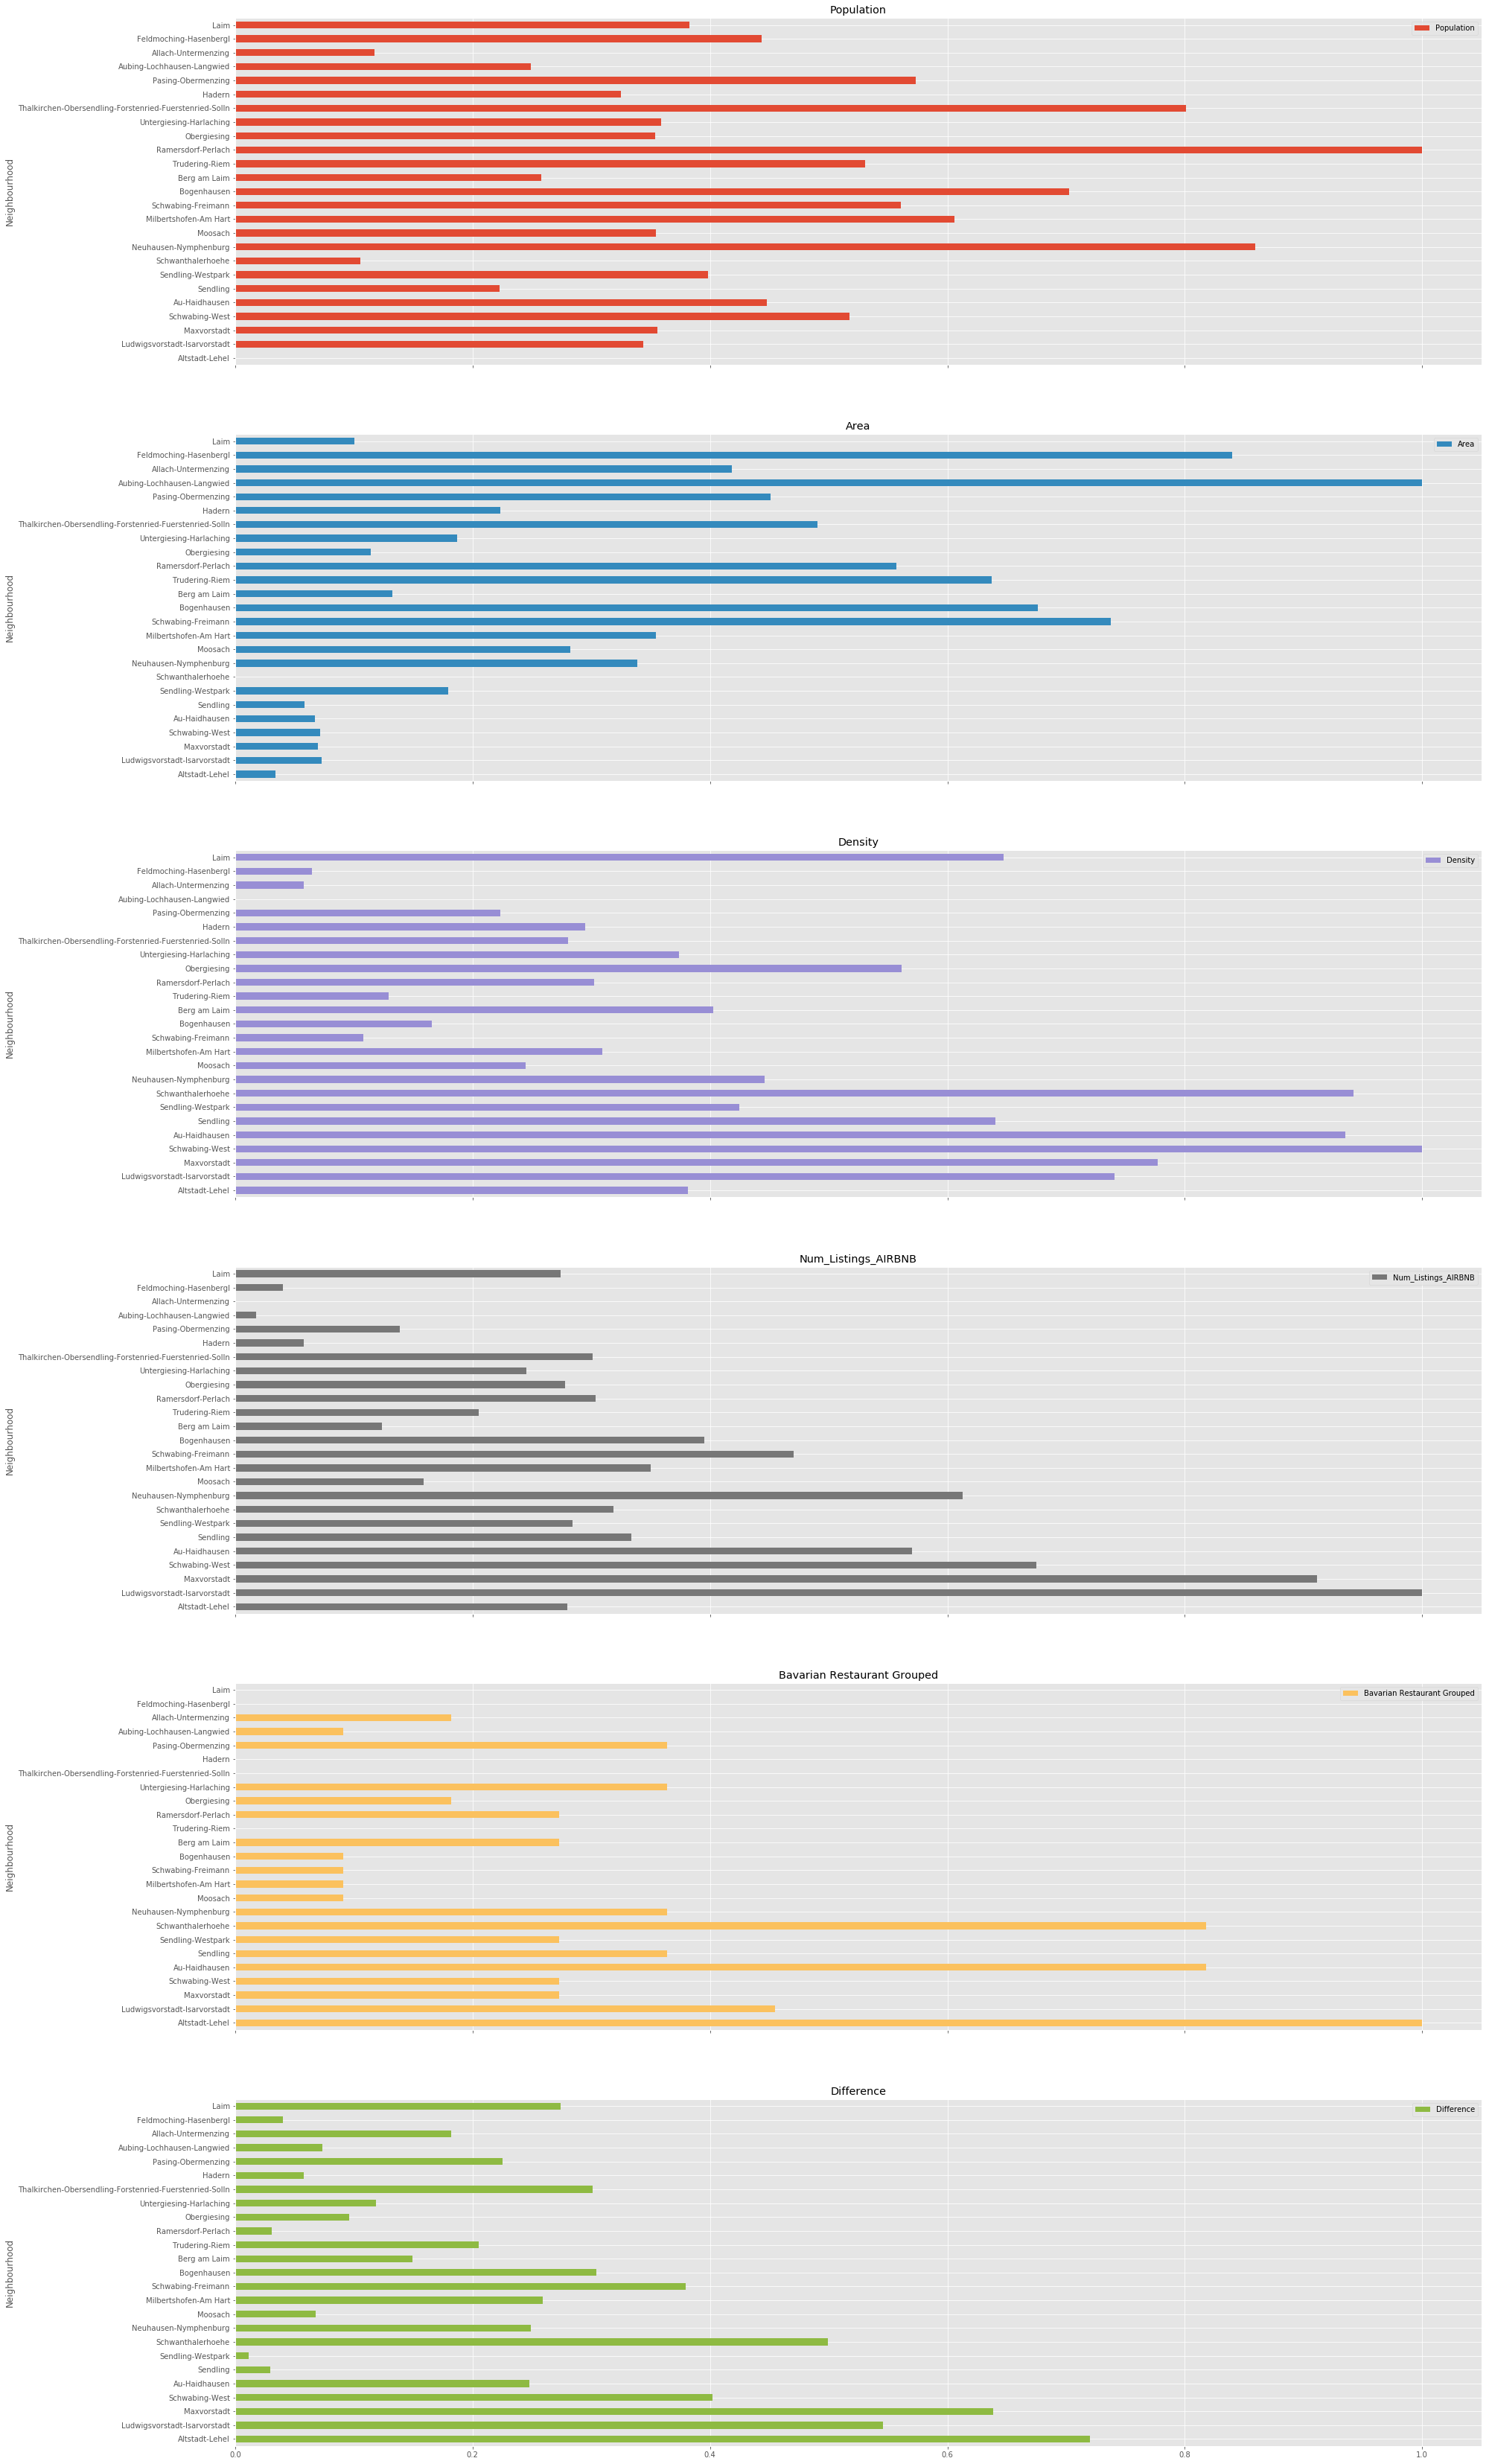

In [47]:
%matplotlib inline

munich_stats_norm.plot(kind = "barh",
                      figsize = (30, 60),
                      subplots = True)


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f3dfebdbc18>],
      dtype=object)

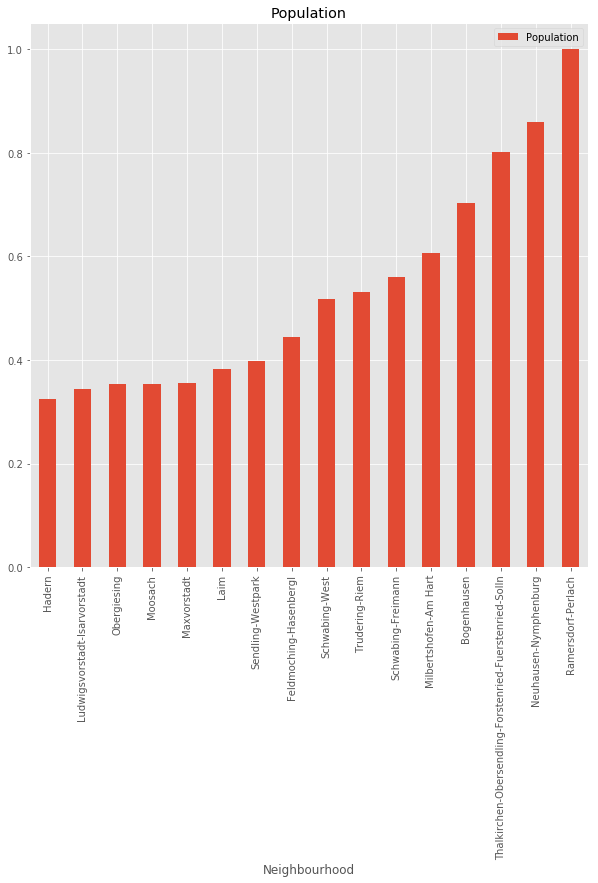

In [68]:
listings_over_restaurants[["Population"]].sort_values(by = "Population").plot(kind = "bar",
                      figsize = (10, 10),
                      subplots = True)
#plt.plot(listings_over_restaurants[["Population","Bavarian Restaurant Grouped"]].sort_values(by = "Population"), color = "black")

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f3dfebdb2e8>],
      dtype=object)

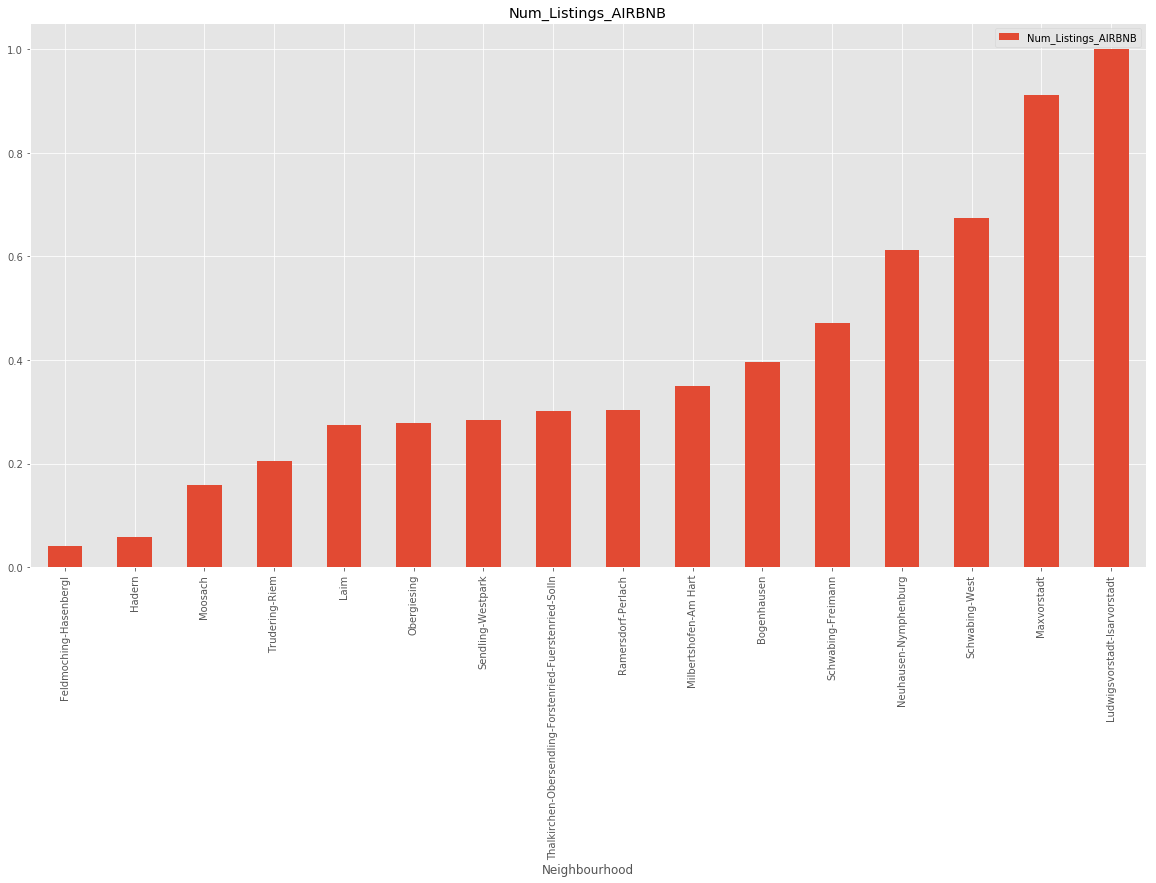

In [69]:
listings_over_restaurants[["Num_Listings_AIRBNB"]].sort_values(by = "Num_Listings_AIRBNB").plot(kind = "bar",
                      figsize = (20, 10),
                      subplots = True)
#plt.plot(listings_over_restaurants[["Num_Listings_AIRBNB", "Bavarian Restaurant Grouped"]].sort_values(by = "Num_Listings_AIRBNB"), color = "black")

### Set a linear Regression model to figure out the dependencies between independent variables and the dependent variable

Based on visually weak correlation a Simple Linear Regression Model is used to quantify the dependency

In [50]:
from sklearn import linear_model

In [51]:
X = munich_stats_norm[["Num_Listings_AIRBNB"]]
y = munich_stats_norm[["Bavarian Restaurant Grouped"]]

regr = linear_model.LinearRegression()
regr.fit(X, y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [52]:
regr.score(X, y)

0.09227861389635494

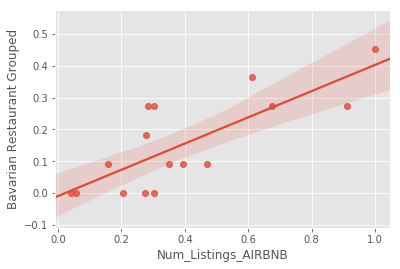

In [53]:
sns.regplot(listings_over_restaurants["Num_Listings_AIRBNB"], listings_over_restaurants["Bavarian Restaurant Grouped"])

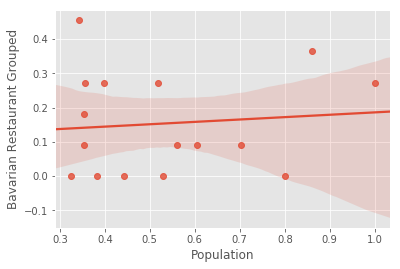

In [66]:
sns.regplot(listings_over_restaurants["Population"], listings_over_restaurants["Bavarian Restaurant Grouped"])